## Load data and RNN weights

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from low_rank_rnns import stats, mante
from low_rank_rnns.modules import FullRankRNN, LowRankRNN
import pandas as pd


In [91]:
# This is how they loaded inputs before. I can't run it because I don't have the *.mat files.

# %%time
# bin_width = 5
# smoothing_width = 50

# # dataset = dlm.ManteDataset(monkey='A', bin_width=bin_width, smoothing_width=smoothing_width, cavg=True)

In [92]:
# I can load their processed monkey neural data. I don't know how to align it to the RNN output though, because constants are messed up.
X_monkeyA = np.load("../data/X_cent_monkeyA.npy")
X_monkeyA.shape # 72 trajectories x 150 time x 727 neurons

(72, 150, 727)

In [93]:
# god help me first need to navigate their data loading
mante.deltaT = 5.
mante.setup()

conditions = pd.read_csv('../data/conditions_monkeyA.csv')
correct_trials = conditions.correct == 1

inputs, _, _ = mante.generate_mante_data_from_conditions(conditions[correct_trials]['stim_dir'].to_numpy(),
                                                         conditions[correct_trials]['stim_col'].to_numpy(),
                                                         conditions[correct_trials]['context'].to_numpy())
inputs.shape

is this the same?


torch.Size([72, 274, 4])

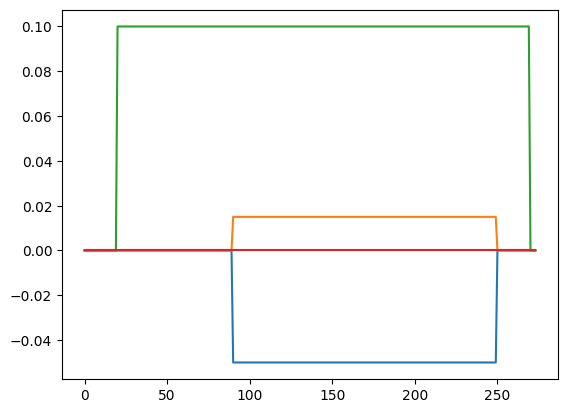

In [97]:
# Task looks reasonable
plt.plot(inputs[9,:,:])

In [13]:
# print(mante.fixation_duration_discrete)
# print(mante.stimulus_duration_discrete)
# print(mante.delay_duration_discrete)
# print(mante.ctx_only_pre_duration_discrete)
# print(mante.decision_duration_discrete)
# print(mante.response_begin)
# print(mante.stim_end)
# print(mante.delay_duration_discrete)

## Get neural trajectories

In [98]:
# Load NN
n_neurons = 727
hidden_neurons = 0

size = n_neurons + hidden_neurons

net_fr = FullRankRNN(4, size, n_neurons, 0, 0.2, output_non_linearity=(lambda x: x))
net_fr.load_state_dict(torch.load('../models/mante_monkeyA_subspace_22.pt'))

net_lr = LowRankRNN(4, size, n_neurons, 0, 0.2, output_non_linearity=(lambda x: x), rank=2)
net_lr.load_state_dict(torch.load('../models/mante_monkeyA_subspace_rank2_22.pt'))

In [99]:
# Run on inputs
_, traj_fr = net_fr(inputs, return_dynamics=True)
traj_fr.shape

torch.Size([72, 275, 727])

In [100]:
# Run on inputs
_, traj_lr = net_lr(inputs, return_dynamics=True)
print(f"fr - lr  = {np.linalg.norm(traj_fr.detach().numpy()-traj_lr.detach().numpy())} (should be teeny tiny!)")

fr - lr  = 972.3126831054688 (should be teeny tiny!)


## Calculate projection matrix

P is subspace spanned by {x[s]}

We have data matrix X, which is s samples x n neurons. (s samples = trajectories * timepoints)
* each row is one sample
* subspace is the row space of X (subspace of R^n)
* P is nxn, an orthogonal projection matrix into row space of X



In [101]:
inputs.shape

torch.Size([72, 274, 4])

In [102]:
# First make data matrix X which should be samples x {num neurons + input}
# X_neurons = X_monkeyA.reshape(-1, X_monkeyA.shape[2]) 
X_neurons = traj_fr[:, 1:, :].reshape(-1, traj_fr.shape[2]) # (72, 274, 727) -> (72*274, 727)
X_input = inputs.reshape(-1, inputs.shape[2]) # (72, 274, 4) -> (72*274, 4)

X_both = torch.cat([torch.tanh(X_neurons), X_input], axis=1).detach().numpy()
X_both.shape

(19728, 731)

In [103]:
# Use SVD to find row space of X (first r right singular vectors with non-zero singular values)
# X = UΣV^T
U, S, VT = np.linalg.svd(X_both, full_matrices=False)

In [104]:
# determine numerical rank
eps = np.finfo(S.dtype).eps
tol = max(X_both.shape) * eps * S.max()
r = np.sum(S > tol)
print(f"X is of rank {r}")

# V_r is n x r
V_r = VT[:r].T   # shape (727, r)

# P = VV^T
P = V_r @ V_r.T

X is of rank 26


In [105]:
# let's test it doesn't affect our x's
x_example = X_both[0]
print(f"|x - Px| = {np.linalg.norm(x_example - (P @ x_example))} (should be teeny tiny!)")

|x - Px| = 0.0 (should be teeny tiny!)


In [106]:
P.shape

(731, 731)

## load weight matrix

In [108]:
print(net_fr.wi.shape) # wi and wi_full are the same hopefully; they run this every forward step self.wi_full = (self.wi.t() * self.si).t() and si seems to be 1s
print(net_fr.wrec.shape)
print(net_fr.wrec.t().shape)
print(net_fr.wi.t().shape)

theta = torch.cat([net_fr.wrec, net_fr.wi.t()], axis=1).detach().numpy() # recurrent weights - (727, 727) + input weights 4x727
# theta = torch.cat([net_fr.wrec.t(), net_fr.wi_full.t()], axis=1).detach().numpy() # recurrent weights - (727, 727) + input weights 4x727
print(theta.shape)

torch.Size([4, 727])
torch.Size([727, 727])
torch.Size([727, 727])
torch.Size([727, 4])
(727, 731)


In [109]:
# let's see about θP
theta_proj = theta @ P
theta_other = theta @ (np.eye(P.shape[0]) - P)

print(f"|θ - (θP + θ(I-P))| = {np.linalg.norm(theta - (theta_proj + theta_other))} (should be teeny tiny!)")

|θ - (θP + θ(I-P))| = 2.033554760217995e-06 (should be teeny tiny!)


In [113]:
device = "cpu" # doesn't work if cuda... 
wrec_proj = torch.tensor(theta_proj[:, :727].T, device=device)
wi_full_proj = torch.tensor(theta_proj[:, 727:].T, device=device)

net_fr_proj = net_fr.clone()

net_fr_proj.wrec = torch.nn.Parameter(wrec_proj)
net_fr_proj.wi = torch.nn.Parameter(wi_full_proj).to(device) # w.si is 1s so this is fine

In [114]:
_, traj_fr_proj = net_fr_proj(inputs, return_dynamics=True)

print(f"normal v proj. θ = {np.linalg.norm(traj_fr.detach().numpy()-traj_fr_proj.detach().numpy())} (should be teeny tiny!)")

r2_global_fr = stats.r2_score(traj_fr_proj.detach().numpy().ravel(), traj_fr.detach().numpy().ravel())
print(f"r2 {r2_global_fr}")

normal v proj. θ = 1788.627685546875 (should be teeny tiny!)
r2 -1.7546436786651611


# IGNORE BELOW HERE

## compare rnn with θP and with ~θ=θP

In [ ]:
import low_rank_rnns.mante as mante 
import pandas as pd

conditions = pd.read_csv('../data/conditions_monkeyA.csv')
correct_trials = conditions.correct == 1

print(mante.fixation_duration_discrete)
print(mante.ctx_only_pre_duration_discrete)
print(mante.stimulus_duration_discrete)
print(mante.delay_duration_discrete)
print(mante.decision_duration_discrete)

print(mante.stim_begin)
print(mante.stim_end)
print(mante.response_begin)
print(mante.total_duration) 

inputs, _, _ = mante.generate_mante_data_from_conditions(conditions[correct_trials]['stim_dir'].to_numpy(),
                                                         conditions[correct_trials]['stim_col'].to_numpy(),
                                                         conditions[correct_trials]['context'].to_numpy())
print(inputs.shape)
print("hi")

is this the same?
torch.Size([72, 220, 4])
hi


In [13]:
print(conditions[correct_trials].shape)

(72, 8)


In [14]:
n_neurons = X.shape[-1]
hidden_neurons = 0

size = n_neurons + hidden_neurons

net_lr = LowRankRNN(4, size, n_neurons, 0, 0.2, output_non_linearity=(lambda x: x))
net_lr.load_state_dict(torch.load('../models/mante_monkeyA_subspace_rank1_22.pt'))

In [15]:
_, traj_lr = net_lr(inputs, return_dynamics=True)
traj_lr = traj_lr.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :][:, :, :n_neurons]

In [16]:
# print(inputs.shape)
_, traj_fr = net_fr(inputs, return_dynamics=True)
traj_fr = traj_fr.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :][:, :, :n_neurons]

In [17]:
_, traj_fr_proj = net_fr_proj(inputs, return_dynamics=True)
traj_fr_proj = traj_fr_proj.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :][:, :, :n_neurons]

In [18]:
print(net_fr.input_size)
print(net_fr.hidden_size)
print(net_fr.output_size)
# print(net_fr.input_size)
# print(net_fr.input_size)

4
727
727


In [19]:
print(inputs.shape)
print(X_monkeyA.shape)
print(traj_fr.shape)

torch.Size([72, 220, 4])
(72, 150, 727)
(72, 150, 727)


In [20]:
# print(traj_fr.shape)

# X_monkey is 72 x 150 x 727
# traj_fr is 72 x 51 x 727
r2_global_fr = stats.r2_score(X_monkeyA.ravel(), traj_fr.ravel())
r2_global_fr

0.048843249617438134

In [21]:
r2_global_fr = stats.r2_score(traj_lr.ravel(), traj_fr.ravel())
r2_global_fr

-0.023505687713623047

In [22]:
print(f"fr - lr  = {np.linalg.norm(traj_fr-traj_lr)} (should be teeny tiny!)")

fr - lr  = 845.100341796875 (should be teeny tiny!)


In [23]:
print(f"normal v proj. θ = {np.linalg.norm(traj_fr-traj_fr_proj)} (should be teeny tiny!)")

normal v proj. θ = 1651.4881591796875 (should be teeny tiny!)


wrt θP:
* P is on the right so it is acting on the input space of θ
* the action of θ on vectors only depends on the components of those vectors inside the span of {x_s}
* P projects row space of θ 